In [9]:
from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import copy
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean
import plotly.graph_objects as go
import pandas as pd
import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict
from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
'''processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")'''


from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor_H = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")

# 加载HuBERT模型
model_H = AutoModelForCTC.from_pretrained("facebook/hubert-large-ls960-ft")

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertForCTC: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForCTC 

In [10]:
human_result_path=r"..\data\test.xlsx"
human_result = pd.read_excel(human_result_path)
human_result_1a=human_result[human_result["Experiment"]=="1a"]

In [11]:
def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]
audio_dir =r"..\Nov10\speech_files"
set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]

In [37]:
from sklearn.manifold import TSNE
def build_tSNE_matrices(audio_dir, set_list, model, processor):
    audio_path=get_pathset(audio_dir)[::-1]
    audio_path=audio_path[:5][::-1]+audio_path[5:][::-1]
    sentences=[[] for i in range(32)]
    
    for each_path in audio_path:
        audio, sr = librosa.load(each_path)
        wave_res = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        tg = textgrid.TextGrid.fromFile(each_path[:-3]+"TextGrid")
        tg_sentence = tg[0]
        for _,i in enumerate(tg[0]):
            if i.mark!="":
                tg_sentence[_-1].maxTime=tg_sentence[_].minTime
        tg_sentence = [i for i in tg_sentence if i.mark!=""]
        tg_sentence=[tg_sentence[i] for i in set_list]
        
        for _, each_sentence in enumerate(tg_sentence):
            start_sentence = int(each_sentence.minTime*16000)
            end_sentence = int(each_sentence.maxTime*16000)
            input=processor(wave_res[start_sentence:end_sentence], sampling_rate=16000, return_tensors="pt").input_values.to(device)
            model.to(device)
            with torch.no_grad():
                #out_encoder=model.hubert(input)[0].cpu().numpy()
                out_encoder=model.hubert.feature_extractor(input).transpose(2,1).cpu().numpy()
            sentences[_].append(out_encoder)
    
    flatten=np.array([x for i in sentences for j in i for x in j[0]])
    tsne = TSNE(n_components=3, random_state=42)
    reduced_data = tsne.fit_transform(flatten)
    
    
    
    torch.cuda.empty_cache()
    return sentences, reduced_data

set_list=set1_list+set2_list
sentence_matrix, reduced_data = build_tSNE_matrices(audio_dir, set_list, model_H, processor_H)

In [38]:

sentence_matrix1=copy.deepcopy(sentence_matrix)
count=0
for _,i in enumerate(sentence_matrix):
    for __,j in enumerate(i):
        sentence_matrix1[_][__]=reduced_data[count:count+j.shape[1]]
        count+=j.shape[1]

In [4]:
import pickle
'''with open("hubert_words_CNN.pkl", "wb") as file:
    pickle.dump(sentence_matrix1, file)'''

'with open("hubert_words_CNN.pkl", "wb") as file:\n    pickle.dump(sentence_matrix1, file)'

In [21]:
with open(".\hubert_words_CNN.pkl", "rb") as file:
    sentence_matrix1 = pickle.load(file)

In [6]:
def get_keywords_dict(human_result_1a):
    '''
    Return a dict, key: sentenceID, values: keywords
    '''
    keywords_dict={}
    for each_ in human_result_1a.values:
        sentenceID=each_[human_result_1a.columns.get_loc("SentenceID")]
        if sentenceID not in keywords_dict:
            keywords_dict[sentenceID]=[]
        keyword=each_[human_result_1a.columns.get_loc("Keyword")]
        if keyword not in keywords_dict[sentenceID]:
            keywords_dict[sentenceID].append(keyword)
    return dict(sorted(keywords_dict.items()))

In [12]:
keywords=get_keywords_dict(human_result_1a)
keywords=[j for i in list(keywords.values()) for j in i]

In [39]:

def create_set(audio_dir, df, reduced_data):
    set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
    set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]
    keywords_dict=get_keywords_dict(df)
    keywords=[j for i in list(keywords_dict.values()) for j in i]
    
    audio_path=get_pathset(audio_dir)[::-1]
    audio_path=audio_path[:5][::-1]+audio_path[5:][::-1]
    #out_dict={}
    
    word_features=[[] for i in range(len(keywords))]
    
    for __, each_path in enumerate(audio_path):
        #audio, sr = librosa.load(each_path)
        #wave_res = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        
        current_talker=os.path.basename(each_path)[:-4]
        #if current_talker not in out_dict.keys():
            #out_dict[current_talker]=[]
        tg = textgrid.TextGrid.fromFile(each_path[:-3]+"TextGrid")
        tg_sentence = tg[0]
        for _,i in enumerate(tg[0]):
            if i.mark!="":
                tg_sentence[_-1].maxTime=tg_sentence[_].minTime
        tg_sentence = [i for i in tg_sentence if i.mark!=""]
        tg_sentence=[tg_sentence[i] for i in set1_list+set2_list]
        tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
        
        count=0
        for _,each_sentence in enumerate(tg_sentence):
            #each_sentence_list=[]
            #start_sentence = int(each_sentence.minTime*16000)
            #end_sentence = int(each_sentence.maxTime*16000)
            
            sentence_total_length=each_sentence.maxTime-each_sentence.minTime
            
            for key_word in list(keywords_dict.values())[_]:
                
                for each_word_tg in tg_word:
                    if each_word_tg.mark.lower()==key_word:
                        if each_word_tg.minTime >= each_sentence.minTime and each_word_tg.maxTime <= each_sentence.maxTime:                        
                            start=each_word_tg.minTime
                            end=each_word_tg.maxTime
                            break

                word_cut_start=start-each_sentence.minTime
                word_cut_end=end-each_sentence.minTime
                word_start=round(reduced_data[_][__].shape[0]*word_cut_start/sentence_total_length)
                word_end=round(reduced_data[_][__].shape[0]*word_cut_end/sentence_total_length)
                
                
                #cut or full.......
                #indices=[xx for xx,i in enumerate(reduced_data[_][__]) if xx>=word_start and xx<=word_end]
                features=reduced_data[_][__][word_start:word_end,:]
                #print(count)
                word_features[count].append(features)
                
                count+=1
                #each_sentence_list.append((letter_label, features))
            #out_dict[current_talker].append(each_sentence_list)

    return word_features
word_features=create_set(audio_dir, human_result_1a, sentence_matrix1)


In [40]:
def create_matrices_word(word_features):
    '''mean = np.mean(reduced_data, axis=0)
    std = np.std(reduced_data, axis=0)
    reduced_data= (reduced_data - mean) / std'''
    
    matrices=[]
    for each_word in word_features:
        each_matrix=[]
        for each_talker1 in each_word:
            each_column=[]
            for each_talker2 in each_word:
                X = each_talker1.transpose()
                Y = each_talker2.transpose()
                combined = np.hstack([X, Y])
                mean = np.mean(combined, axis=1, keepdims=True)
                std = np.std(combined, axis=1, keepdims=True)
                std[std == 0] = 1
                
                X_normalized = (X - mean) / std
                Y_normalized = (Y - mean) / std
                #print(X.shape,Y.shape)
                D, wp = librosa.sequence.dtw(X_normalized, Y_normalized, metric='euclidean')
                combined_length = X.shape[1] + Y.shape[1]
                normalized_distance = D[-1, -1] / combined_length
                each_column.append(normalized_distance)
            each_matrix.append(each_column)
        matrices.append(np.array(each_matrix))
    return matrices
out_ = create_matrices_word(word_features)

In [44]:
matrix=copy.deepcopy(np.mean(out_,axis=0))
matrix[np.isnan(matrix)]=0 
part1 = matrix[0:5, 0:5]
part2 = matrix[5:11, 5:11]

part3_1 = matrix[0:5, 5:]
part3_2 = matrix[5:, 0:5]
part3=np.concatenate((part3_1,part3_2.T))

part1 = np.delete(part1.ravel(), np.where(part1.ravel()==0.))
part2 = np.delete(part2.ravel(), np.where(part2.ravel()==0.))
part3 = np.delete(part3.ravel(), np.where(part3.ravel()==0.))

print("Mean native talker-to-talker distance: ",f"{np.nanmean(part1):.5f}",
      "\nMean non-native talker-to-talker distance: ", f"{np.nanmean(part2):.5f}",
      "\nMean native-to-non-native talker-to-talker distance: ", f"{np.nanmean(part3):.5f}")

print("\nMedian native talker-to-talker distance: ",f"{np.nanmedian(part1):.5f}",
      "\nMedian non-native talker-to-talker distance: ", f"{np.nanmedian(part2):.5f}",
      "\nMedian native-to-non-native talker-to-talker distance: ", f"{np.nanmedian(part3):.5f}")

print("\nstd native talker-to-talker distance: ",f"{np.nanstd(part1):.5f}",
      "\nstd non-native talker-to-talker distance: ", f"{np.nanstd(part2):.5f}",
      "\nstd native-to-non-native talker-to-talker distance: ", f"{np.nanstd(part3):.5f}")

print("\nstd_error native talker-to-talker distance: ",f"{np.nanmedian(part1)/np.sqrt(len(part1.ravel())):.5f}",
      "\nstd_error non-native talker-to-talker distance: ", f"{np.nanmedian(part2)/np.sqrt(len(part2.ravel())):.5f}",
      "\nstd_error native-to-non-native talker-to-talker distance: ", f"{np.nanmedian(part3)/np.sqrt(len(part3.ravel())):.5f}")

Mean native talker-to-talker distance:  0.77689 
Mean non-native talker-to-talker distance:  0.82381 
Mean native-to-non-native talker-to-talker distance:  0.89700

Median native talker-to-talker distance:  0.81622 
Median non-native talker-to-talker distance:  0.84901 
Median native-to-non-native talker-to-talker distance:  0.89608

std native talker-to-talker distance:  0.14378 
std non-native talker-to-talker distance:  0.09472 
std native-to-non-native talker-to-talker distance:  0.11722

std_error native talker-to-talker distance:  0.18251 
std_error non-native talker-to-talker distance:  0.15501 
std_error native-to-non-native talker-to-talker distance:  0.11568


In [141]:
matrix=np.array(out_)
matrix=np.exp(-1*matrix)
df = pd.DataFrame(columns=['condition', 'similarity'])
#matrix_list1=[]
for i in range(1,5):
    for j in range(i):
        for x in matrix[:,i,j]:
            df.loc[len(df)] = ['native-to-native', x]#.append(matrix[:,i,j])
        
#matrix_list2=[]

        #matrix_list2.append(matrix[:,i,j])
        
#matrix_list3=[]
for i in range(6,11):
    for j in range(i):
        for x in matrix[:,i,j]:
            df.loc[len(df)] = ['nonnative-to-nonnative', x]
            
for i in range(5,11):
    for j in range(5):
        for x in matrix[:,i,j]:
            df.loc[len(df)] = ['native-to-nonnative', x]
        #matrix_list3.append(matrix[:,i,j])
        

        

C:\Users\Alex\AppData\Local\Temp\ipykernel_97396\1263815239.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="condition", y="similarity", data=df, alpha=0.2, size=1.5, palette=palette)


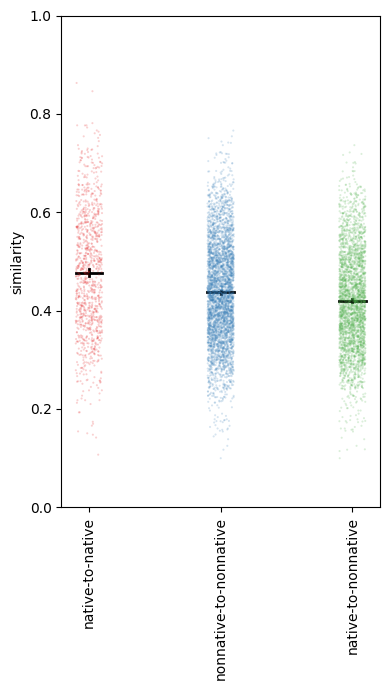

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


means = df.groupby('condition')['similarity'].mean()
cis = df.groupby('condition')['similarity'].apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)))

plt.figure(figsize=(4, 7)) 
palette = sns.color_palette("Set1", n_colors=df['condition'].nunique())

sns.stripplot(x="condition", y="similarity", data=df, alpha=0.2, size=1.5, palette=palette)

for i, condition in enumerate(df['condition'].unique()):
    mean = means[condition]
    ci_low, ci_high = cis[condition]
    plt.plot([i - 0.1, i + 0.1], [mean, mean], color="black", linewidth=2)
    plt.plot([i, i], [ci_low, ci_high], color="black", linewidth=2)

plt.xticks(rotation=90)
plt.xlabel("")
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [ ]:
np.array(out_).shape
matrix=copy.deepcopy(np.mean(out_,axis=0))
matrix[np.isnan(matrix)]=0 
part1 = matrix[0:5, 0:5]
part2 = matrix[5:11, 5:11]

part3_1 = matrix[0:5, 5:]
part3_2 = matrix[5:, 0:5]
part3=np.concatenate((part3_1,part3_2.T))

(103, 11, 11)

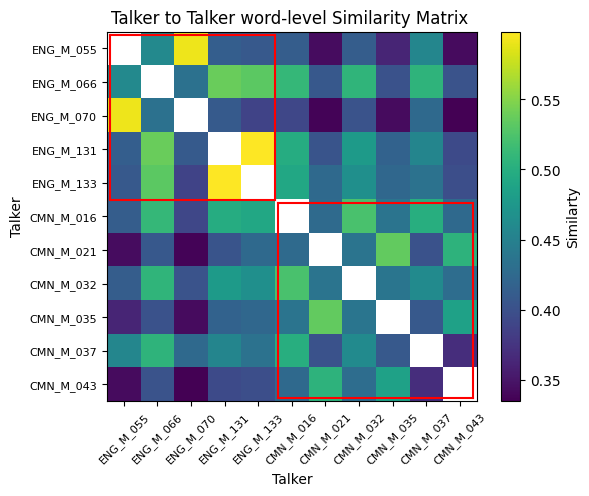

In [41]:
import copy

audio_path=get_pathset(audio_dir)[::-1]
audio_path=audio_path[:5][::-1]+audio_path[5:][::-1]
from scipy.stats import mannwhitneyu
from matplotlib.lines import Line2D
import matplotlib
talkers=[i[26:35][-3:]+"_M_"+i[26:35][:3] for i in audio_path]
#
def plot_confusion_matrix(out_):
    out_ = np.exp(-1*np.array(out_))
    count = np.median(out_,axis=0)
    np.fill_diagonal(count, np.nan)
    norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
    plt.imshow(count, cmap='viridis', interpolation='nearest')#,norm=norm
    plt.title("Talker to Talker word-level Similarity Matrix ")
    plt.xticks(ticks=np.arange(len(talkers)), labels=talkers, rotation=45,fontsize=8)
    plt.yticks(ticks=np.arange(len(talkers)), labels=talkers, fontsize=8)
    plt.xlabel("Talker")
    plt.ylabel("Talker")
    plt.plot([-0.4, -0.4], [-0.4, 4.5], color='red', ls='-')
    plt.plot([-0.4, 4.5], [-0.4, -0.4], color='red', ls='-')
    plt.plot([4.5, 4.5], [-0.4, 4.5], color='red', ls='-')
    plt.plot([-0.4, 4.5], [4.5, 4.5], color='red', ls='-')
    
    plt.plot([4.6, 4.6], [4.6, 10.4], color='red', ls='-')
    plt.plot([4.6, 10.4], [10.4, 10.4], color='red', ls='-')
    plt.plot([10.4, 10.4], [10.4, 4.6], color='red', ls='-')
    plt.plot([10.4, 4.6], [4.6, 4.6], color='red', ls='-')

    non_native_values = count[5:, 5:].flatten()
    native_values = count[:5, :5].flatten()

    non_native_values = non_native_values[~np.isnan(non_native_values)]
    native_values = native_values[~np.isnan(native_values)]

    u_stat3, p_value3 = mannwhitneyu(non_native_values, native_values)
    ax = plt.gca()
    '''ax.text(
        0.5, -0.1, f"\n\nU={u_stat3:.2f}, p={p_value3:.7f}",
        transform=ax.transAxes, fontsize=10, color="black",
        ha="center", va="center"
    )'''
    custom_line = Line2D([0], [0], color='red', linestyle='--')
    
    #plt.legend(handles=[custom_line], labels=['Native'], loc='upper left', bbox_to_anchor=(1, 1))
    cbar = plt.colorbar(shrink=1,label="Similarty")
    cbar.ax.yaxis.set_label_position('right')
    plt.show()

plot_confusion_matrix(out_)

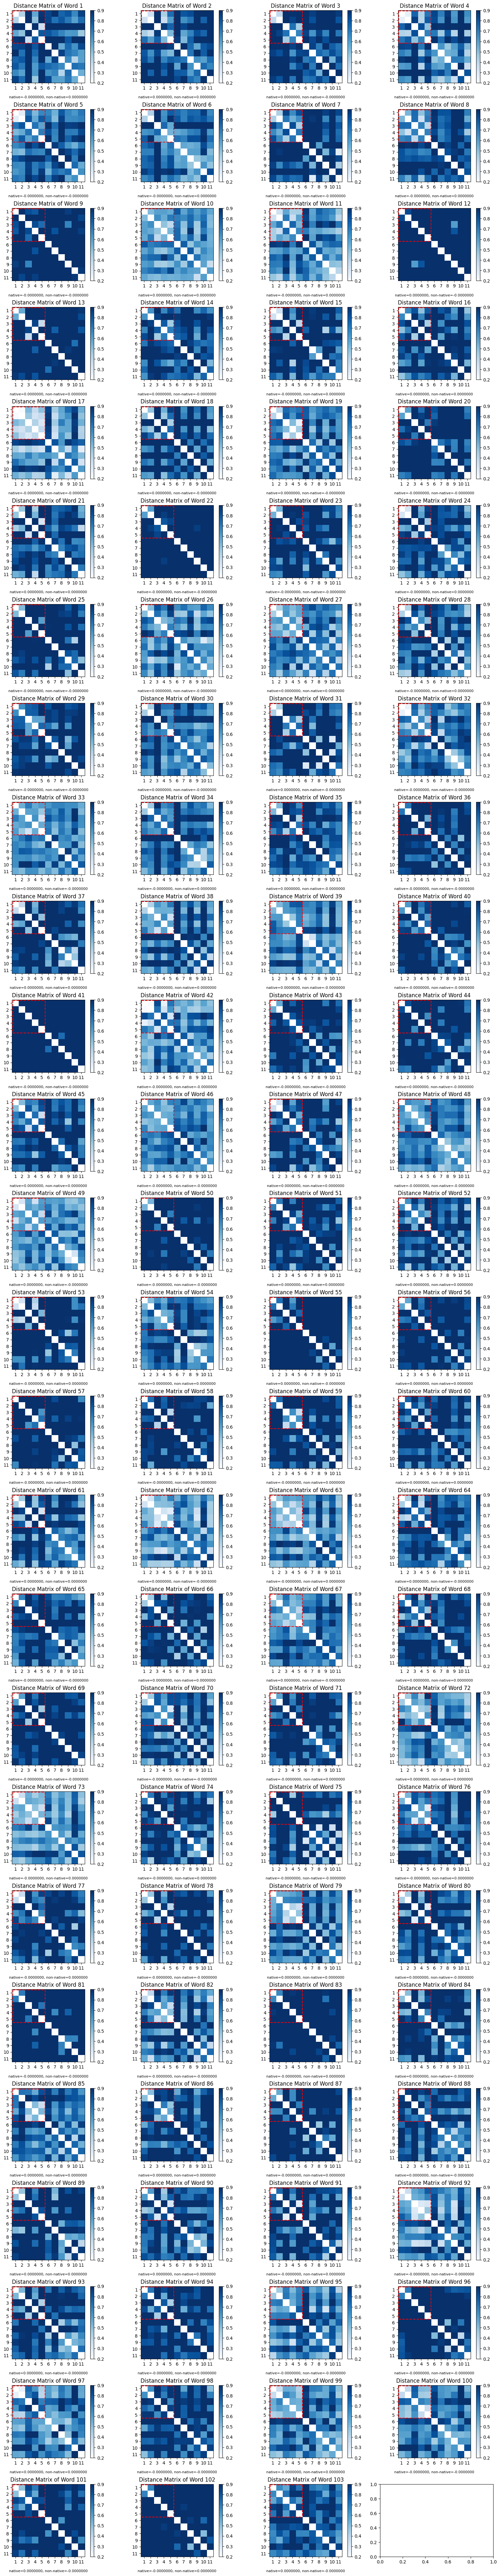

In [41]:
import numpy as np
import matplotlib.pyplot as plt

#conf_matrices = np.random.randint(0, 100, (32, 11, 11))
fig, axes = plt.subplots(26, 4, figsize=(16, 80))
p_values=[]
for i in range(len(out_)):
    matrix = out_[i]
    np.fill_diagonal(matrix, np.nan)
    ax = axes[i // 4, i % 4]


    norm = matplotlib.colors.Normalize(vmin=0.2 ,vmax=0.9)
    cax = ax.imshow(matrix, cmap='Blues', interpolation='nearest',norm=norm)
    

    ax.set_title(f"Distance Matrix of Word {i + 1}")
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))


    ax.set_xticklabels(np.arange(1, 12)) 
    ax.set_yticklabels(np.arange(1, 12))
    
    ax.plot([-0.4, -0.4], [-0.4, 4.5], color='red', ls='--')
    ax.plot([-0.4, 4.5], [-0.4, -0.4], color='red', ls='--')
    ax.plot([4.5, 4.5], [-0.4, 4.5], color='red', ls='--')
    ax.plot([-0.4, 4.5], [4.5, 4.5], color='red', ls='--')

    fig.colorbar(cax, ax=ax)
    native_values = matrix[:5, :5].flatten()
    non_native_values = matrix[5:, 5:].flatten()  
    

    non_native_values = non_native_values[~np.isnan(non_native_values)]
    native_values = native_values[~np.isnan(native_values)]
    #print(non_native_values)
    from scipy.stats import zscore
    native = zscore(native_values)
    nonnative = zscore(non_native_values)
    #u_stat, p_value = mannwhitneyu(non_native_values, native_values)
    ax.text(
        0.5, -0.2, f"native={np.mean(native):.7f}, non-native={np.mean(nonnative):.7f}",
        transform=ax.transAxes, fontsize=8, color="black",
        ha="center", va="center"
    )
    #p_values.append(p_value)
    

plt.tight_layout()
plt.show()
